In [8]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns

from dataset import get_dataset
from preprocessing import preprocessData


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exploration
- **t0s0**: Occupancy rate of the current train at the next station (value to predict).
  
- **t1s0**: Occupancy rate of the previous train at the same station.
- **t2s0**: Occupancy rate of the second previous train at the same station.
- **t3s0**: Occupancy rate of the third previous train at the same station.
  
- **t0s1**: Occupancy rate of the same train at the previous station.
- **t0s2**: Occupancy rate of the same train at the second previous station.
- **t0s3**: Occupancy rate of the same train at the third previous station.

In [9]:
df_train, df_test = get_dataset()

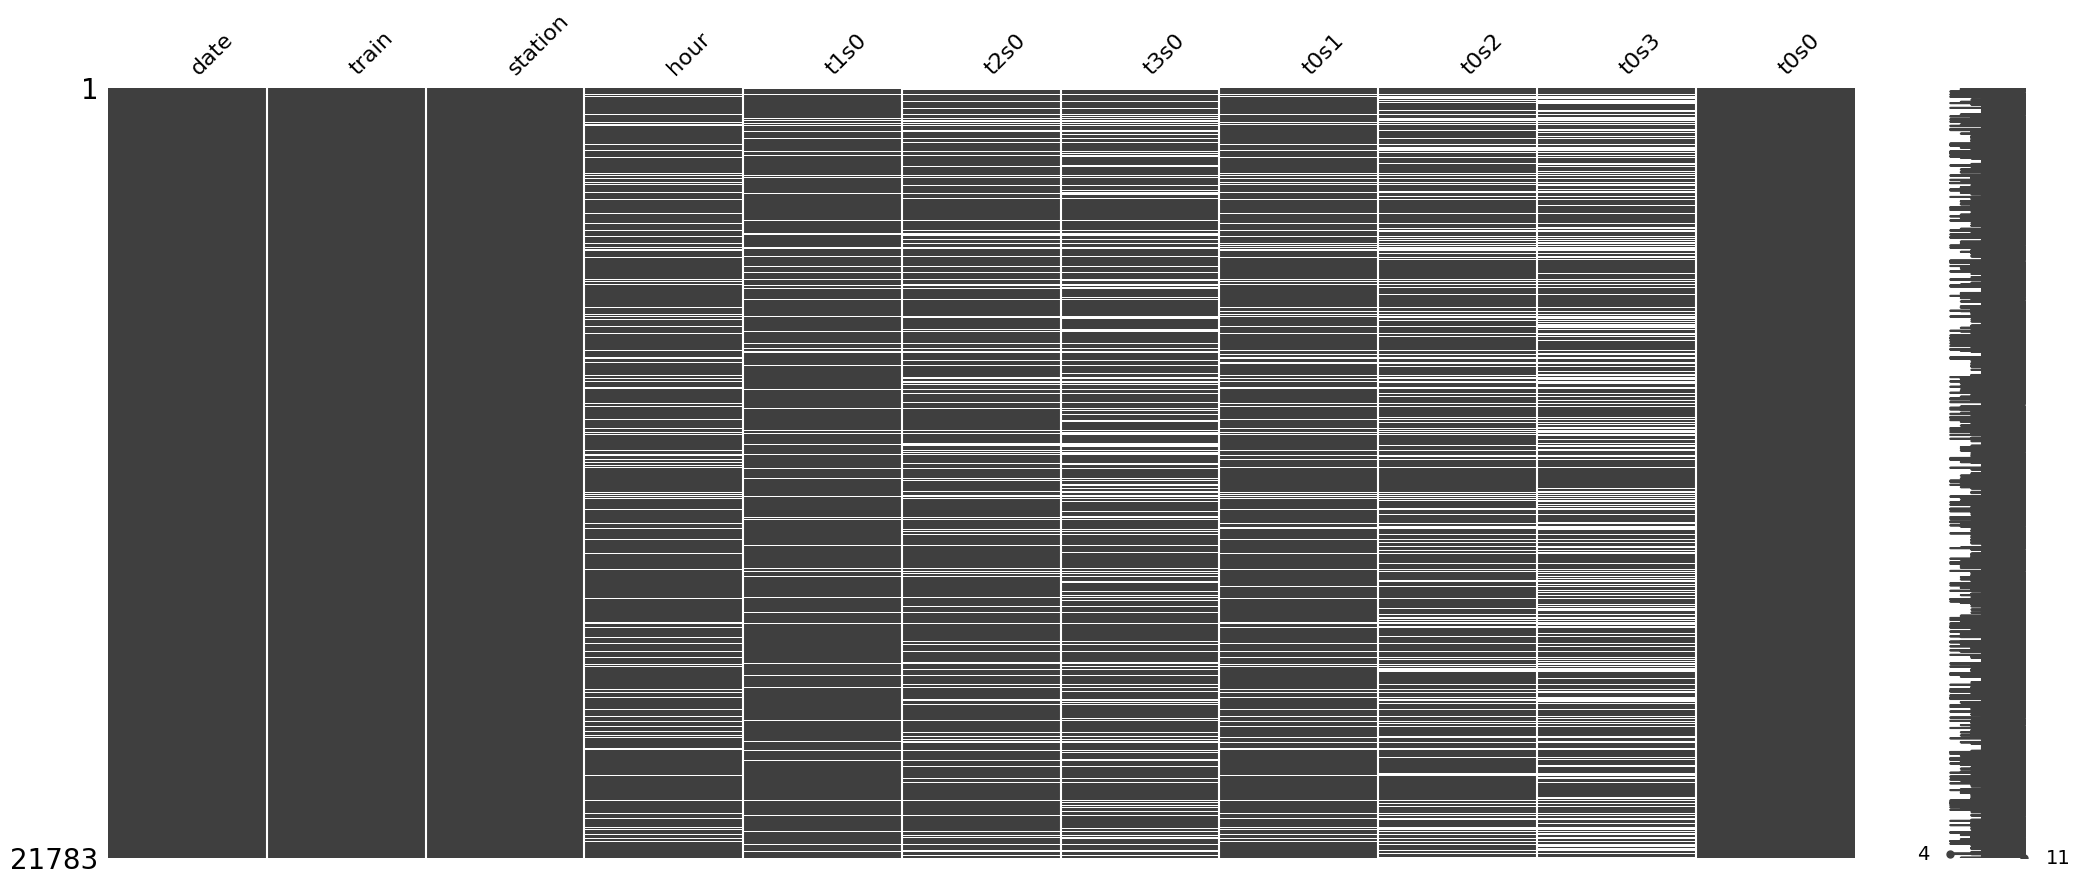

In [10]:
# Visualize missing data
msno.matrix(df_train)
plt.show()

In [11]:
# There are 5 unique values for the hour
print(df_train['hour'].unique())

['08:00:00' '06:00:00' '07:00:00' nan '09:00:00' '11:00:00']


In [12]:
# Print number of stations
stations = df_train['station'].unique()
print(stations)
print("Number of stations:", len(stations))

['AZ' 'AD' 'BC' 'AE' 'AM' 'AL' 'AJ' 'BB' 'AN' 'BA' 'AX' 'AI' 'AK' 'AW'
 'AG' 'AU' 'BD' 'AQ' 'AR' 'AB' 'AP' 'AO' 'BF' 'AF' 'AA' 'AH' 'AV' 'AC'
 'AS' 'BJ' 'BH' 'AT' 'AY' 'BE' 'BG' 'BI']
Number of stations: 36


In [13]:
# Print number of row for each station:
stations_map = {}
for station in stations:
    stations_map[station] = len(df_train[df_train['station'] == station])

# Order the stations by number of rows
sorted_stations = sorted(stations_map.items(), key=lambda x: x[1], reverse=True)
print(sorted_stations)

[('AJ', 2232), ('BB', 1818), ('AK', 1332), ('AI', 1270), ('AZ', 959), ('BC', 886), ('AL', 878), ('AO', 876), ('AQ', 862), ('AF', 491), ('AE', 482), ('AP', 470), ('BG', 460), ('AC', 458), ('AG', 456), ('AU', 456), ('AT', 449), ('AW', 448), ('AH', 448), ('AD', 441), ('BE', 437), ('AM', 435), ('BD', 434), ('AX', 419), ('BH', 418), ('AB', 413), ('AS', 411), ('AN', 410), ('BF', 402), ('AV', 391), ('AA', 268), ('BI', 246), ('BA', 244), ('BJ', 239), ('AR', 226), ('AY', 218)]


# Stations visualization

In [14]:
# Cast from hh:mm:ss to datetime and extract the hour, then convert to int
df_train['hour_num'] = pd.to_datetime(df_train['hour'], format='%H:%M:%S').dt.hour
df_test['hour_num'] = pd.to_datetime(df_test['hour'], format='%H:%M:%S').dt.hour

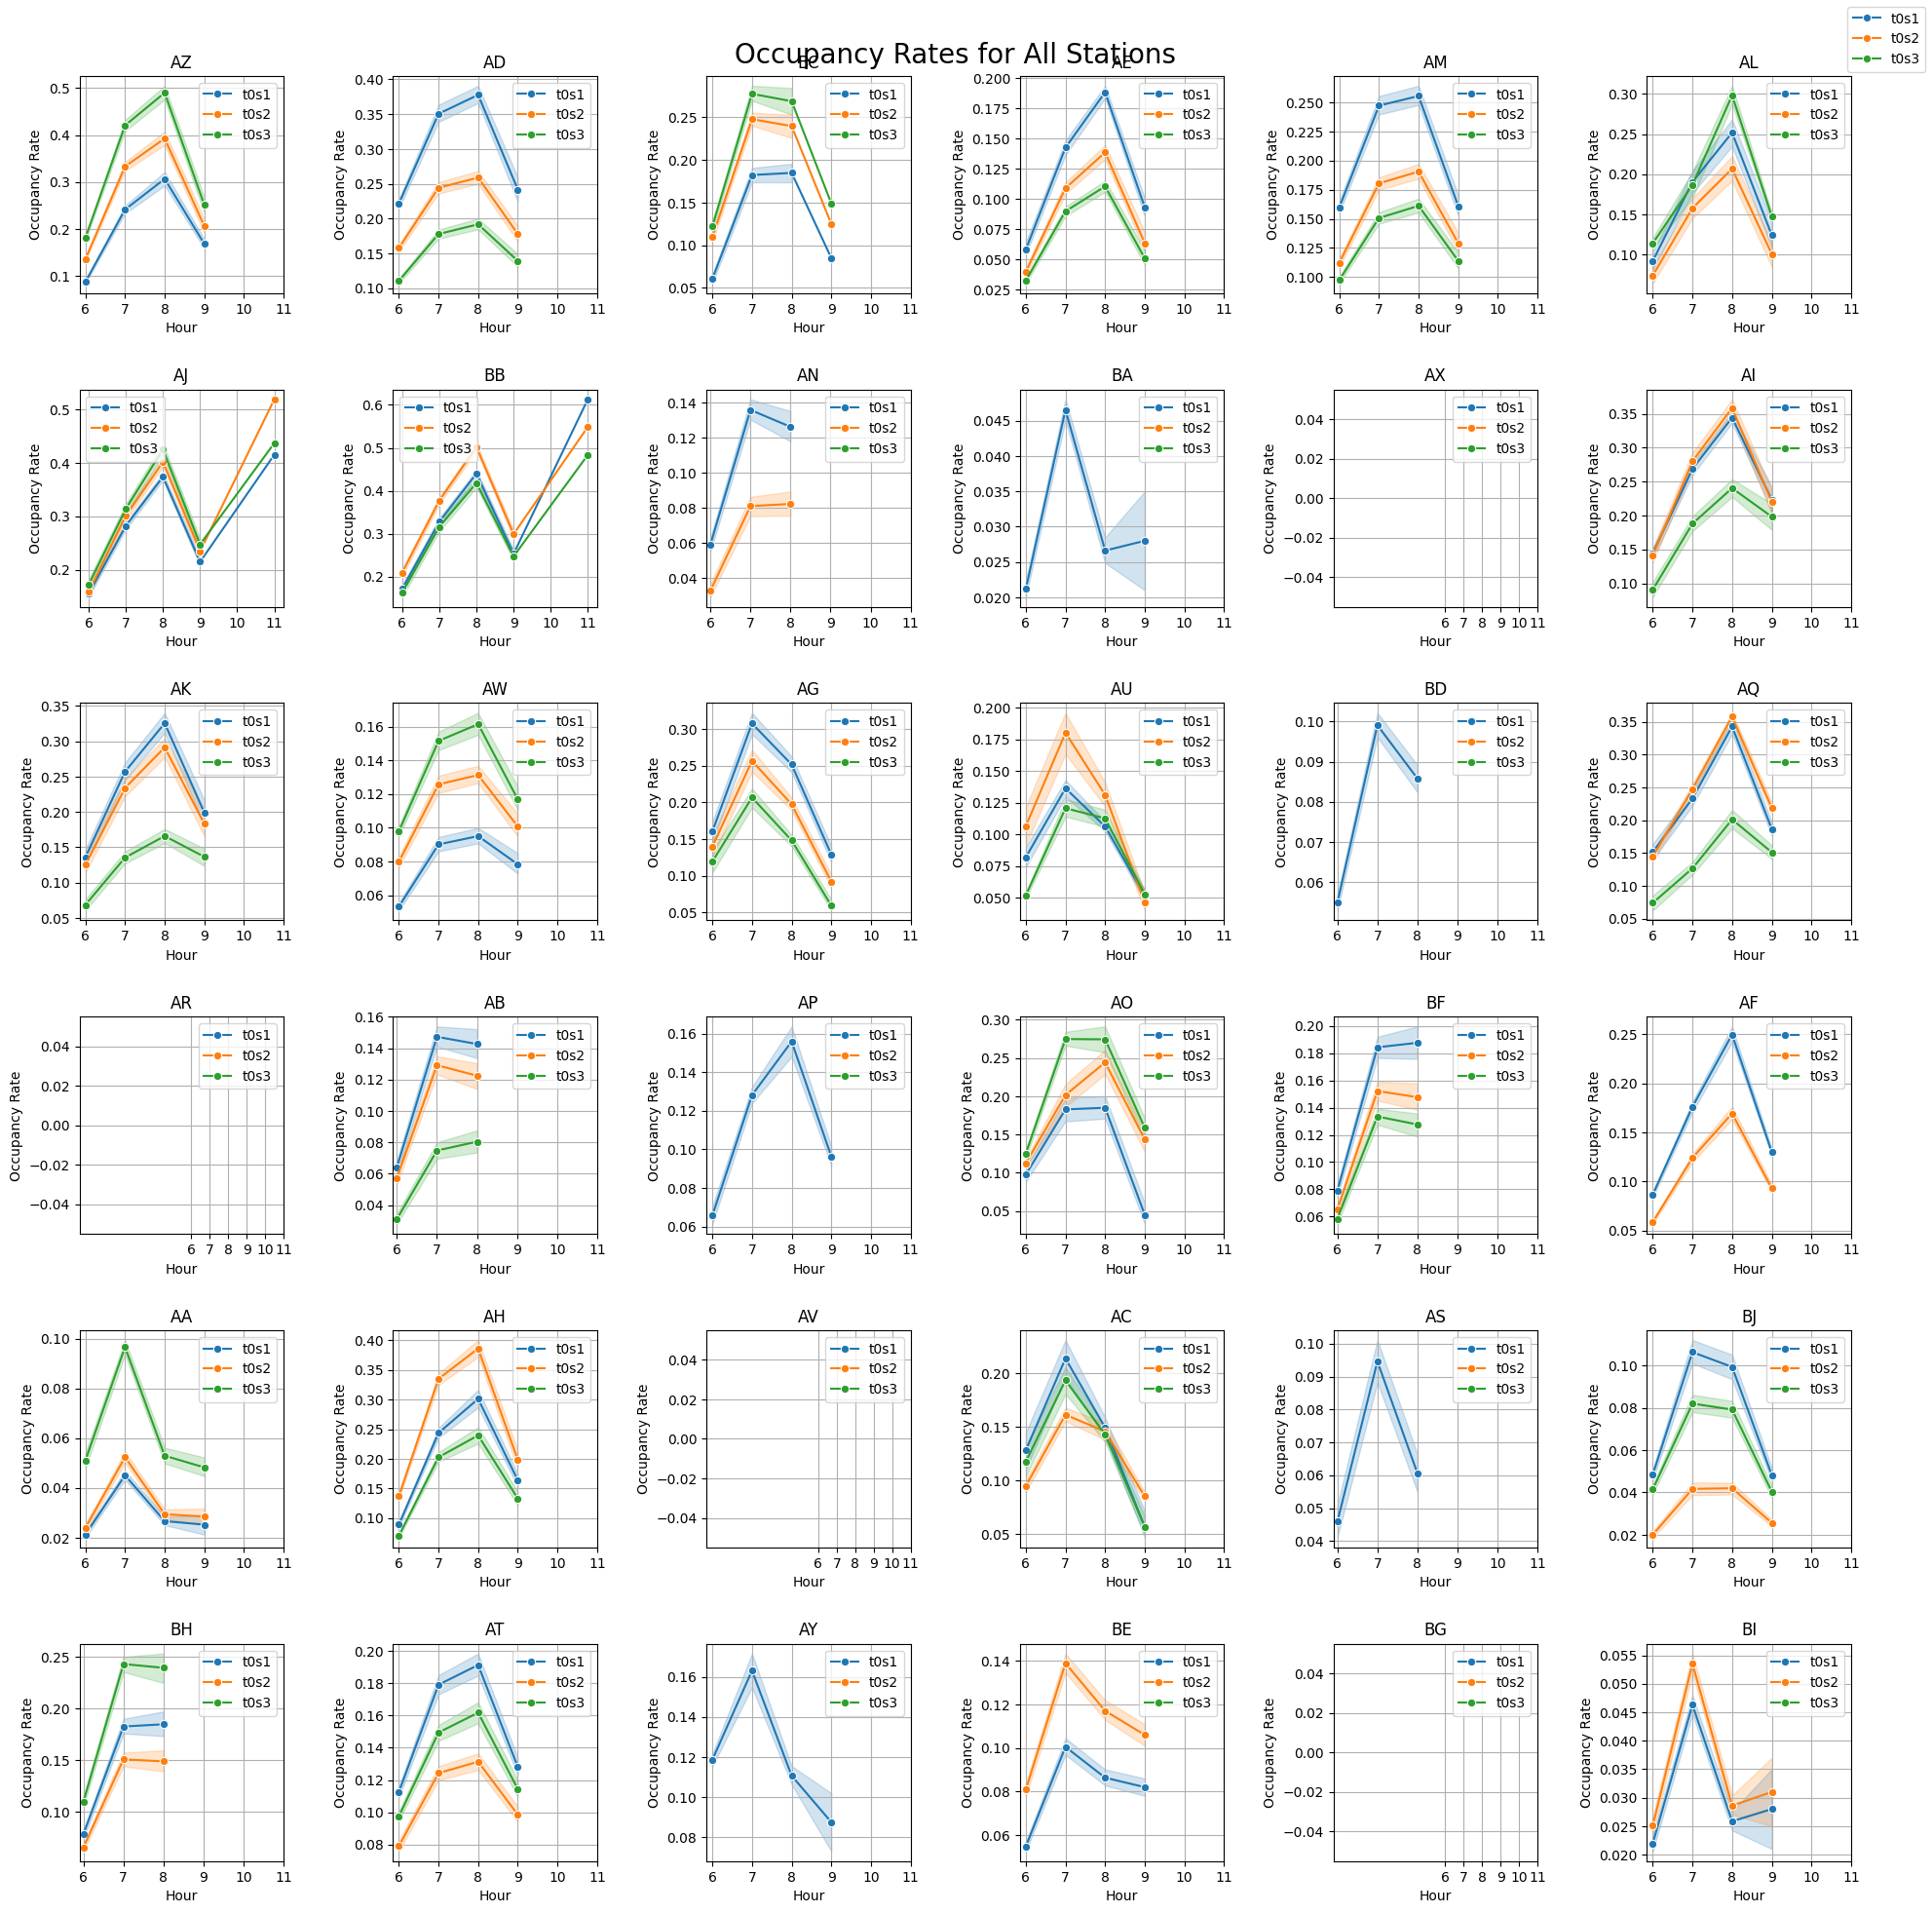

In [15]:
# Create plot grid
min_hour = df_train['hour_num'].min().astype(int)
max_hour = df_train['hour_num'].max().astype(int)

fig, axs = plt.subplots(6, 6, figsize=(20, 20))
fig.tight_layout(pad=5.0)

for i, station in enumerate(stations):
    row = i // 6
    col = i % 6
    filtered_df = df_train[df_train['station'] == station]

    sns.lineplot(data=filtered_df, x='hour_num', y='t0s1', marker='o', label='t0s1', ax=axs[row, col])
    sns.lineplot(data=filtered_df, x='hour_num', y='t0s2', marker='o', label='t0s2', ax=axs[row, col])
    sns.lineplot(data=filtered_df, x='hour_num', y='t0s3', marker='o', label='t0s3', ax=axs[row, col])
    axs[row, col].set_title(f'{station}')
    axs[row, col].set_xticks(range(min_hour, max_hour + 1))
    axs[row, col].grid(True)
    axs[row, col].set_ylabel('Occupancy Rate')
    axs[row, col].set_xlabel('Hour')

# Set common title and legend
fig.suptitle('Occupancy Rates for All Stations', fontsize=20)
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.show()

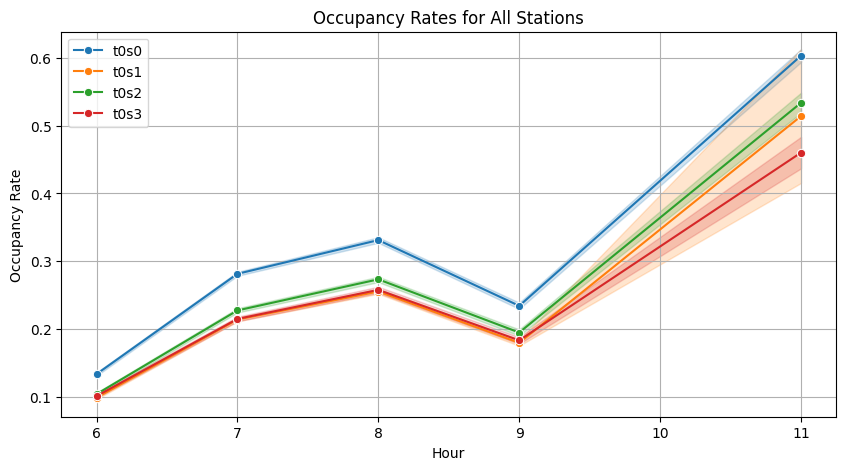

In [16]:
# Now one graph to see occupancy rates for all stations
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=df_train, x='hour_num', y='t0s0', marker='o', label='t0s0')
sns.lineplot(data=df_train, x='hour_num', y='t0s1', marker='o', label='t0s1')
sns.lineplot(data=df_train, x='hour_num', y='t0s2', marker='o', label='t0s2')
sns.lineplot(data=df_train, x='hour_num', y='t0s3', marker='o', label='t0s3')
ax.set_title('Occupancy Rates for All Stations')
ax.set_ylabel('Occupancy Rate')
ax.set_xlabel('Hour')
ax.set_xticks(range(min_hour, max_hour + 1))
ax.grid(True)
plt.legend()

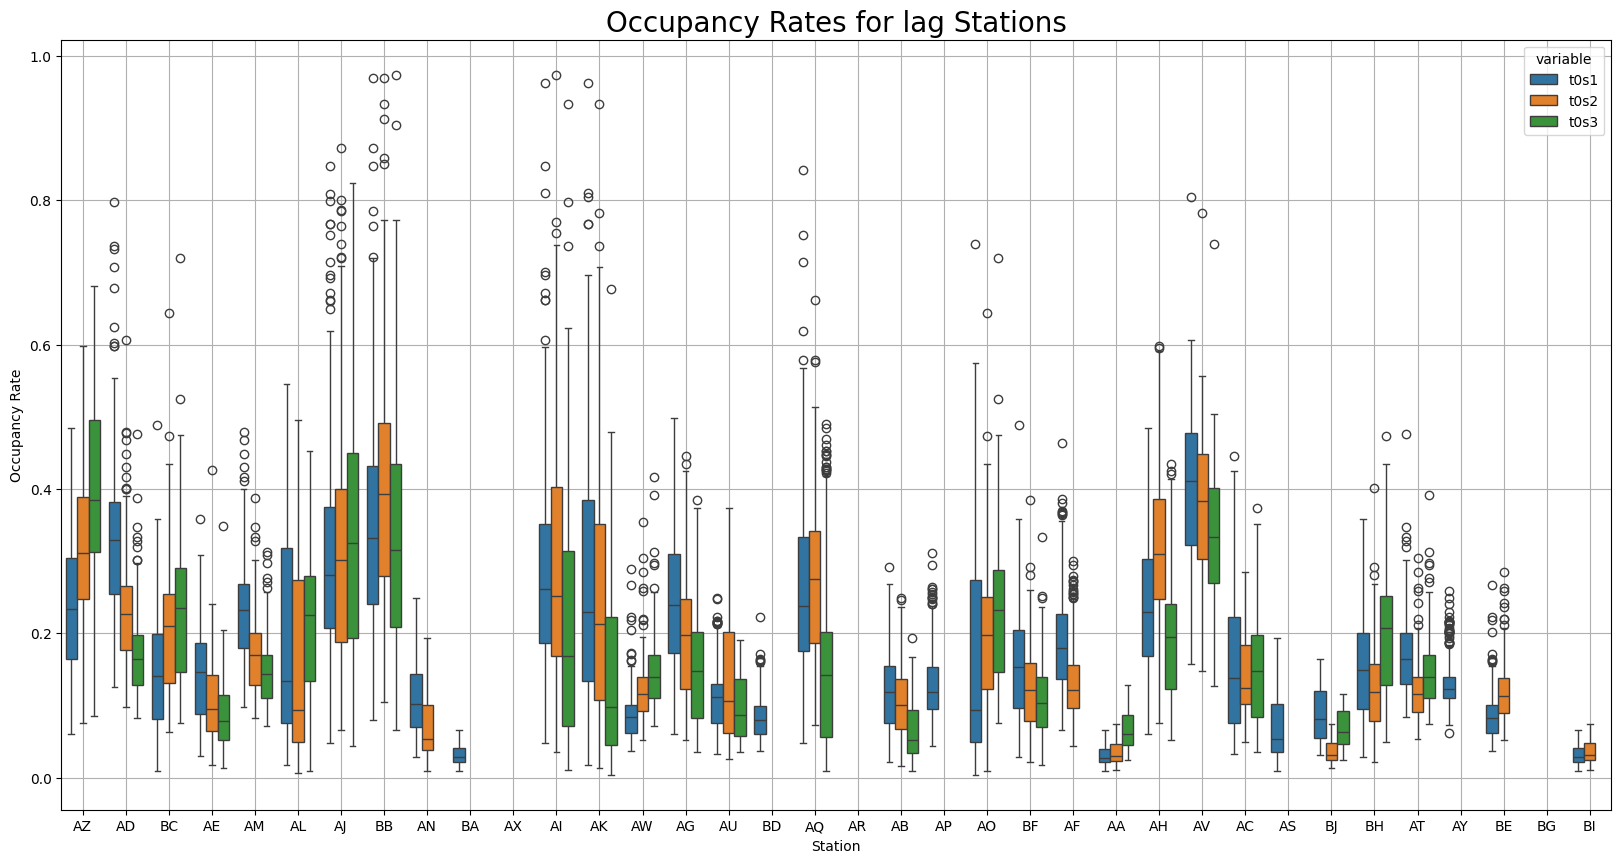

In [17]:
cols = ['t0s1', 't0s2', 't0s3']
sorted_stations_avg_station = df_train.groupby('station')[cols].mean()
sorted_stations_avg_station = sorted_stations_avg_station.mean(axis=1).sort_values(ascending=False)

# Melt the dataframe to have a long format suitable for seaborn boxplot
melted_df = df_train.melt(id_vars=['station'], value_vars=cols, var_name='variable', value_name='value')

# Print the occupancy rates for each station in a single box plot
plt.figure(figsize=(20, 10))
sns.boxplot(data=melted_df, x='station', y='value', hue='variable') #, order=sorted_stations_avg_station.index)
plt.title('Occupancy Rates for lag Stations', fontsize=20)
plt.ylabel('Occupancy Rate')
plt.xlabel('Station')
plt.grid(True)
plt.show()


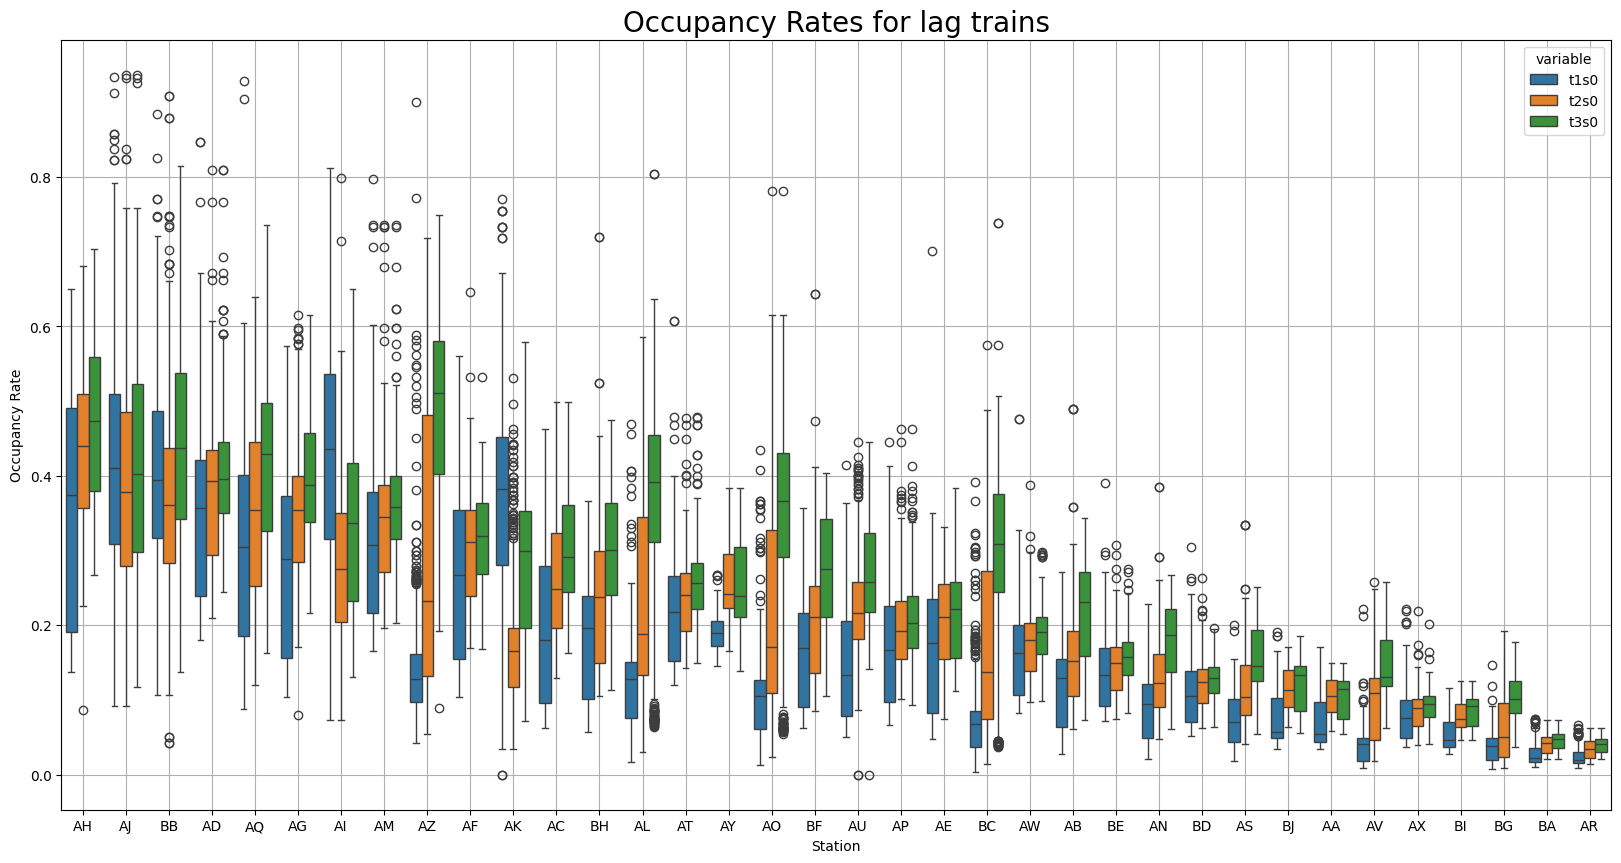

In [18]:
cols = ['t1s0', 't2s0', 't3s0']
stations_lag_train = df_train.groupby('station')[cols].mean()
stations_avg_lag_train = stations_lag_train.mean(axis=1).sort_values(ascending=False)

# Melt the dataframe to have a long format suitable for seaborn boxplot
melted_df = df_train.melt(id_vars=['station'], value_vars=cols, var_name='variable', value_name='value')

# Print the occupancy rates for each station in a single box plot
plt.figure(figsize=(20, 10))
sns.boxplot(data=melted_df, x='station', y='value', hue='variable', order=stations_avg_lag_train.index)
plt.title('Occupancy Rates for lag trains', fontsize=20)
plt.ylabel('Occupancy Rate')
plt.xlabel('Station')
plt.grid(True)
plt.show()

In [19]:
# Replace station by its average occupancy rate with respect to the 3 lag stations and the 3 lag trains
df_train['station_avg_lag_train'] = df_train['station'].map(sorted_stations_avg_station)
df_train['station_avg_lag_station'] = df_train['station'].map(stations_avg_lag_train)

In [20]:
df_train['day_of_week'] = pd.to_datetime(df_train['date'], format='%Y-%m-%d').dt.dayofweek

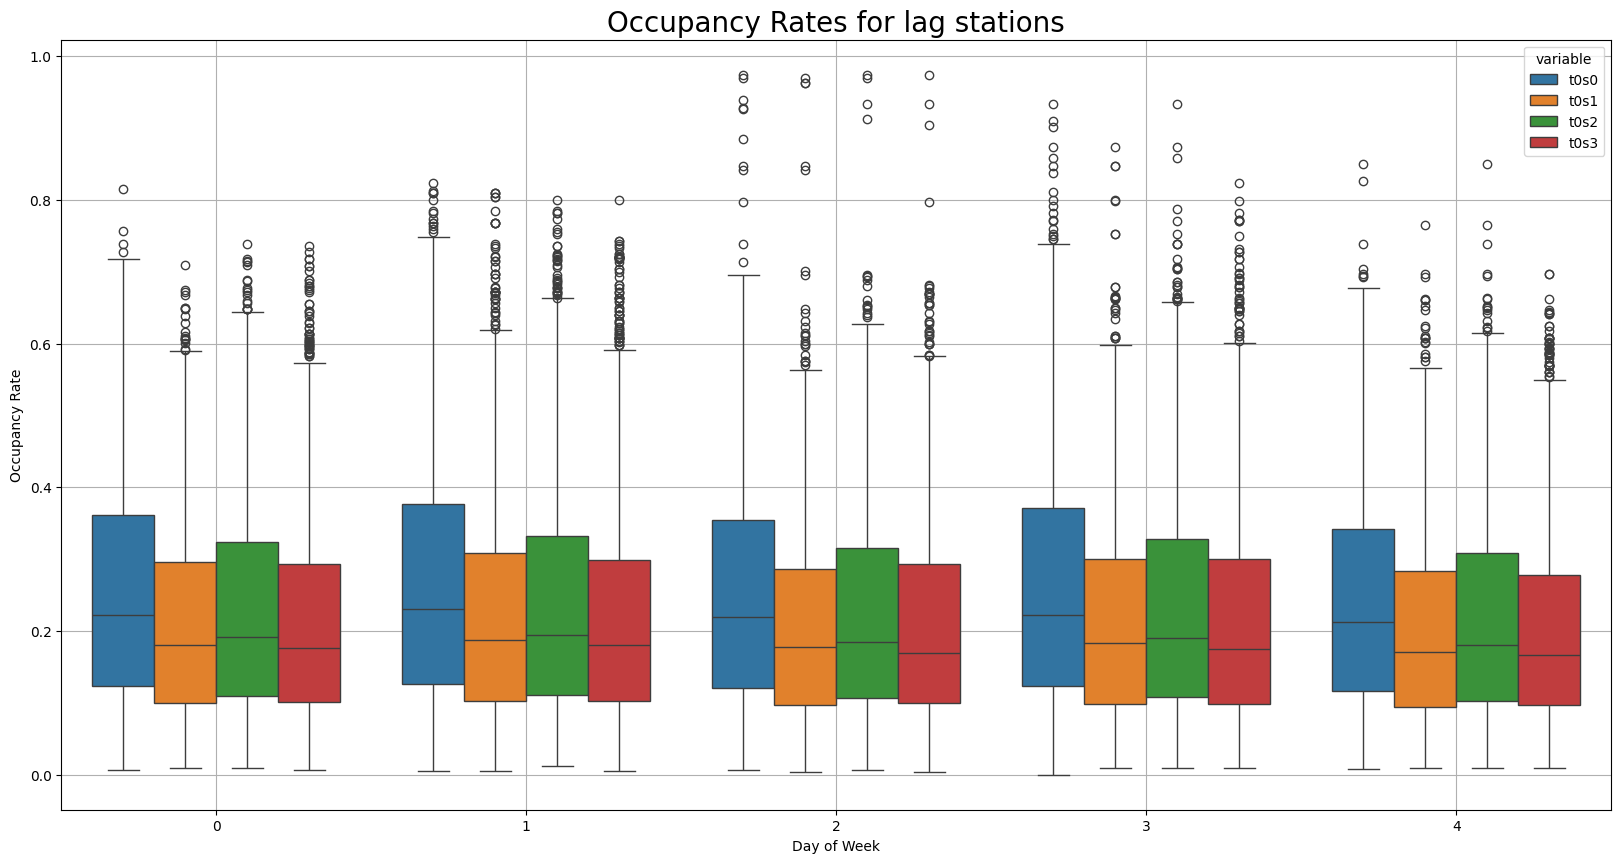

In [21]:
cols = ['t0s0', 't0s1', 't0s2', 't0s3']
# Melt the dataframe to have a long format suitable for seaborn boxplot
melted_df = df_train.melt(id_vars=['day_of_week'], value_vars=cols, var_name='variable', value_name='value')

# Print the occupancy rates for each station in a single box plot
plt.figure(figsize=(20, 10))
sns.boxplot(data=melted_df, x='day_of_week', y='value', hue='variable')
plt.title('Occupancy Rates for lag stations', fontsize=20)
plt.ylabel('Occupancy Rate')
plt.xlabel('Day of Week')
plt.grid(True)
plt.show()

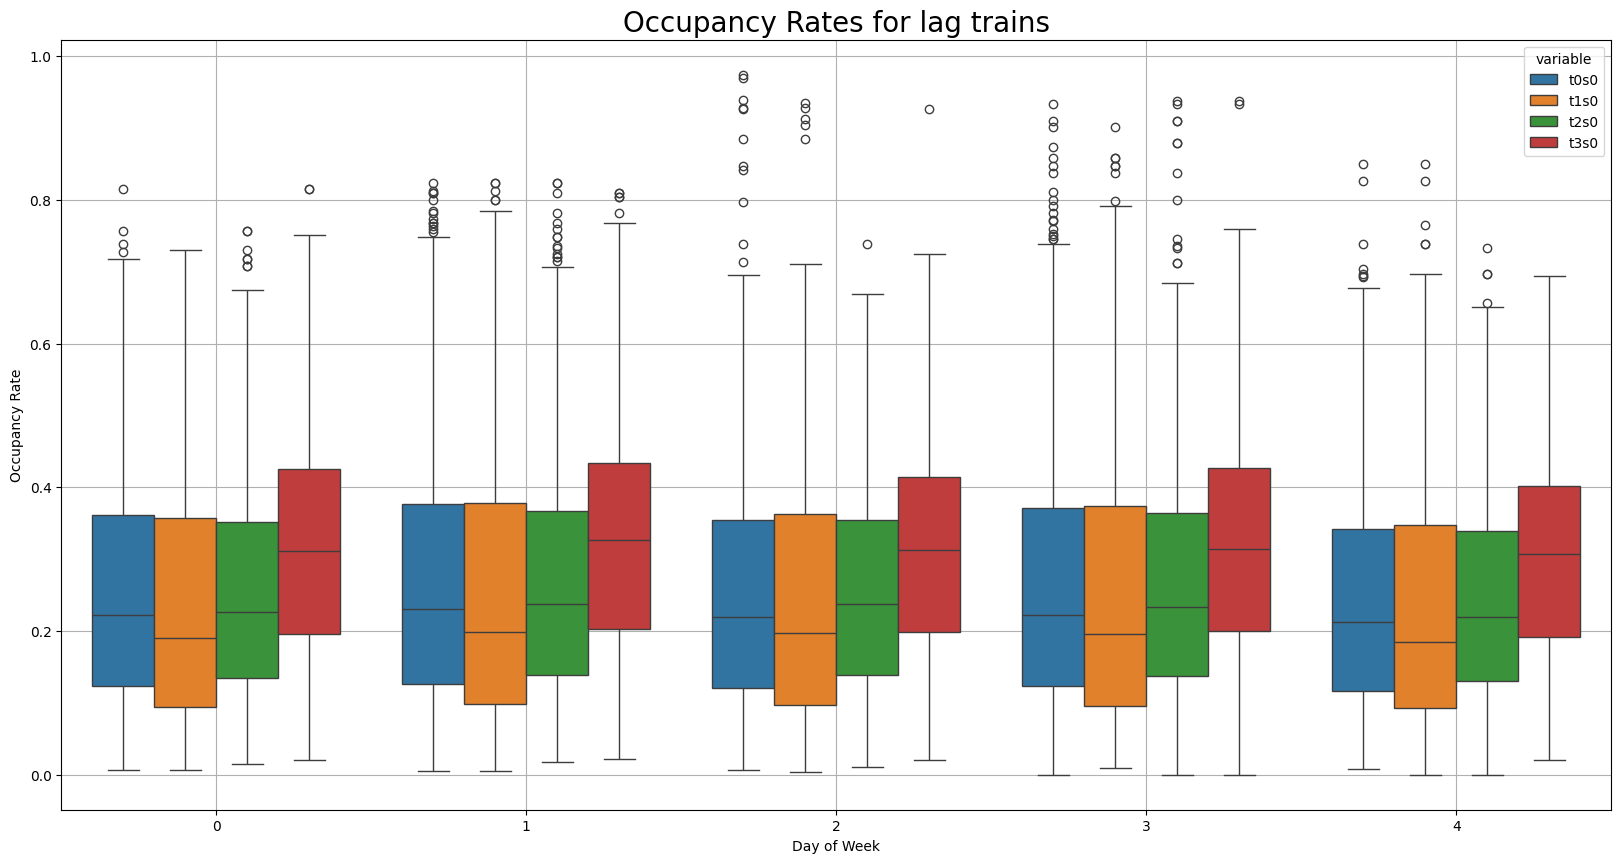

In [22]:
cols = ['t0s0', 't1s0', 't2s0', 't3s0']
# Melt the dataframe to have a long format suitable for seaborn boxplot
melted_df = df_train.melt(id_vars=['day_of_week'], value_vars=cols, var_name='variable', value_name='value')

# Print the occupancy rates for each station in a single box plot
plt.figure(figsize=(20, 10))
sns.boxplot(data=melted_df, x='day_of_week', y='value', hue='variable')
plt.title('Occupancy Rates for lag trains', fontsize=20)
plt.ylabel('Occupancy Rate')
plt.xlabel('Day of Week')
plt.grid(True)
plt.show()

### Observations:
- Composition in the test set is constant equal to 2.
- way is constant equal to 1.

# Correlations


In [23]:
from pandas.plotting import scatter_matrix

lag_features = ['t1s0', 't2s0', 't3s0', 't0s1', 't0s2', 't0s3', 't0s0']
all_features = ['station_avg_lag_train',
                'station_avg_lag_station', 'day_of_week', 'hour_num'] + lag_features

<Figure size 2000x2000 with 0 Axes>

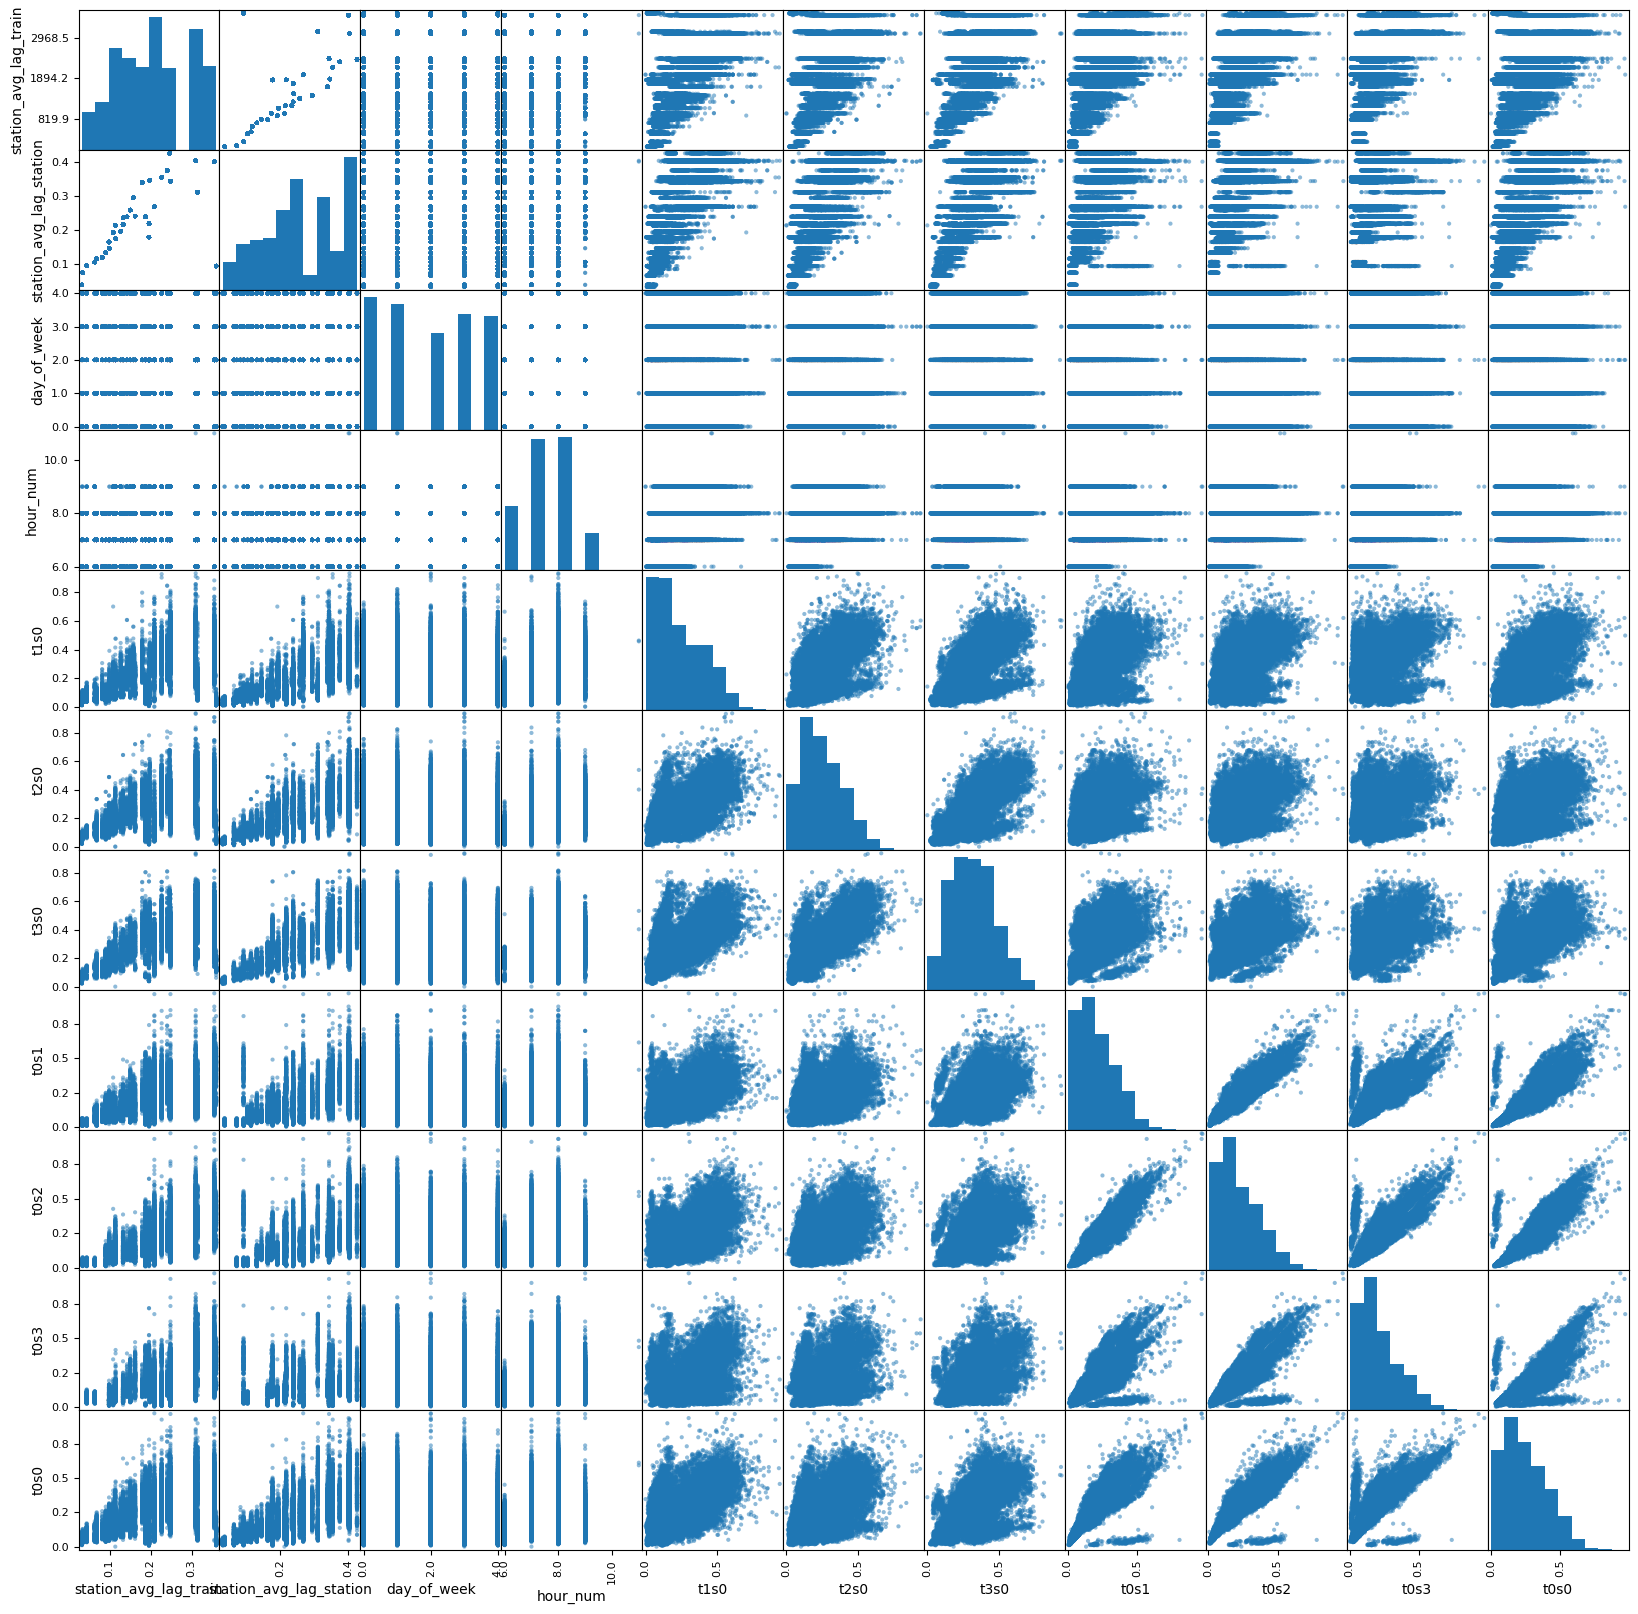

In [24]:
# Define the columns to plot


# Create the scatter matrix plot
plt.figure(figsize=(20, 20))
sm = scatter_matrix(df_train[all_features], figsize=(20, 20))

# Fix the axis labels to two decimal places
for ax in sm.ravel():
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1f}'))

plt.show()

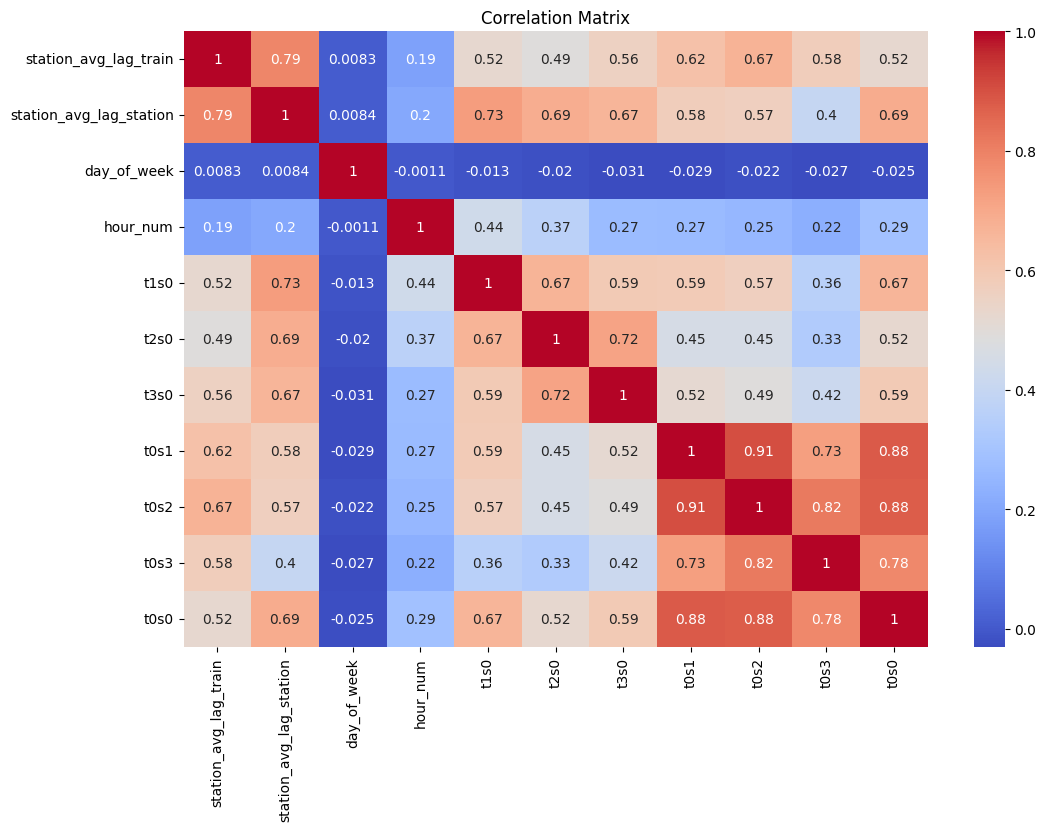

In [25]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_train[all_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [26]:
#! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/feature_engineering.py
import feature_engineering

features_corr = feature_engineering.get_features_correlated_to_target(
    df_train[all_features], target_feature='t0s0')

print(features_corr)

t0s0                       1.00
t0s1                       0.88
t0s2                       0.88
t0s3                       0.78
station_avg_lag_station    0.69
t1s0                       0.67
t3s0                       0.59
station_avg_lag_train      0.52
t2s0                       0.52
hour_num                   0.29
day_of_week               -0.03
Name: t0s0, dtype: float64


<Figure size 2000x2000 with 0 Axes>

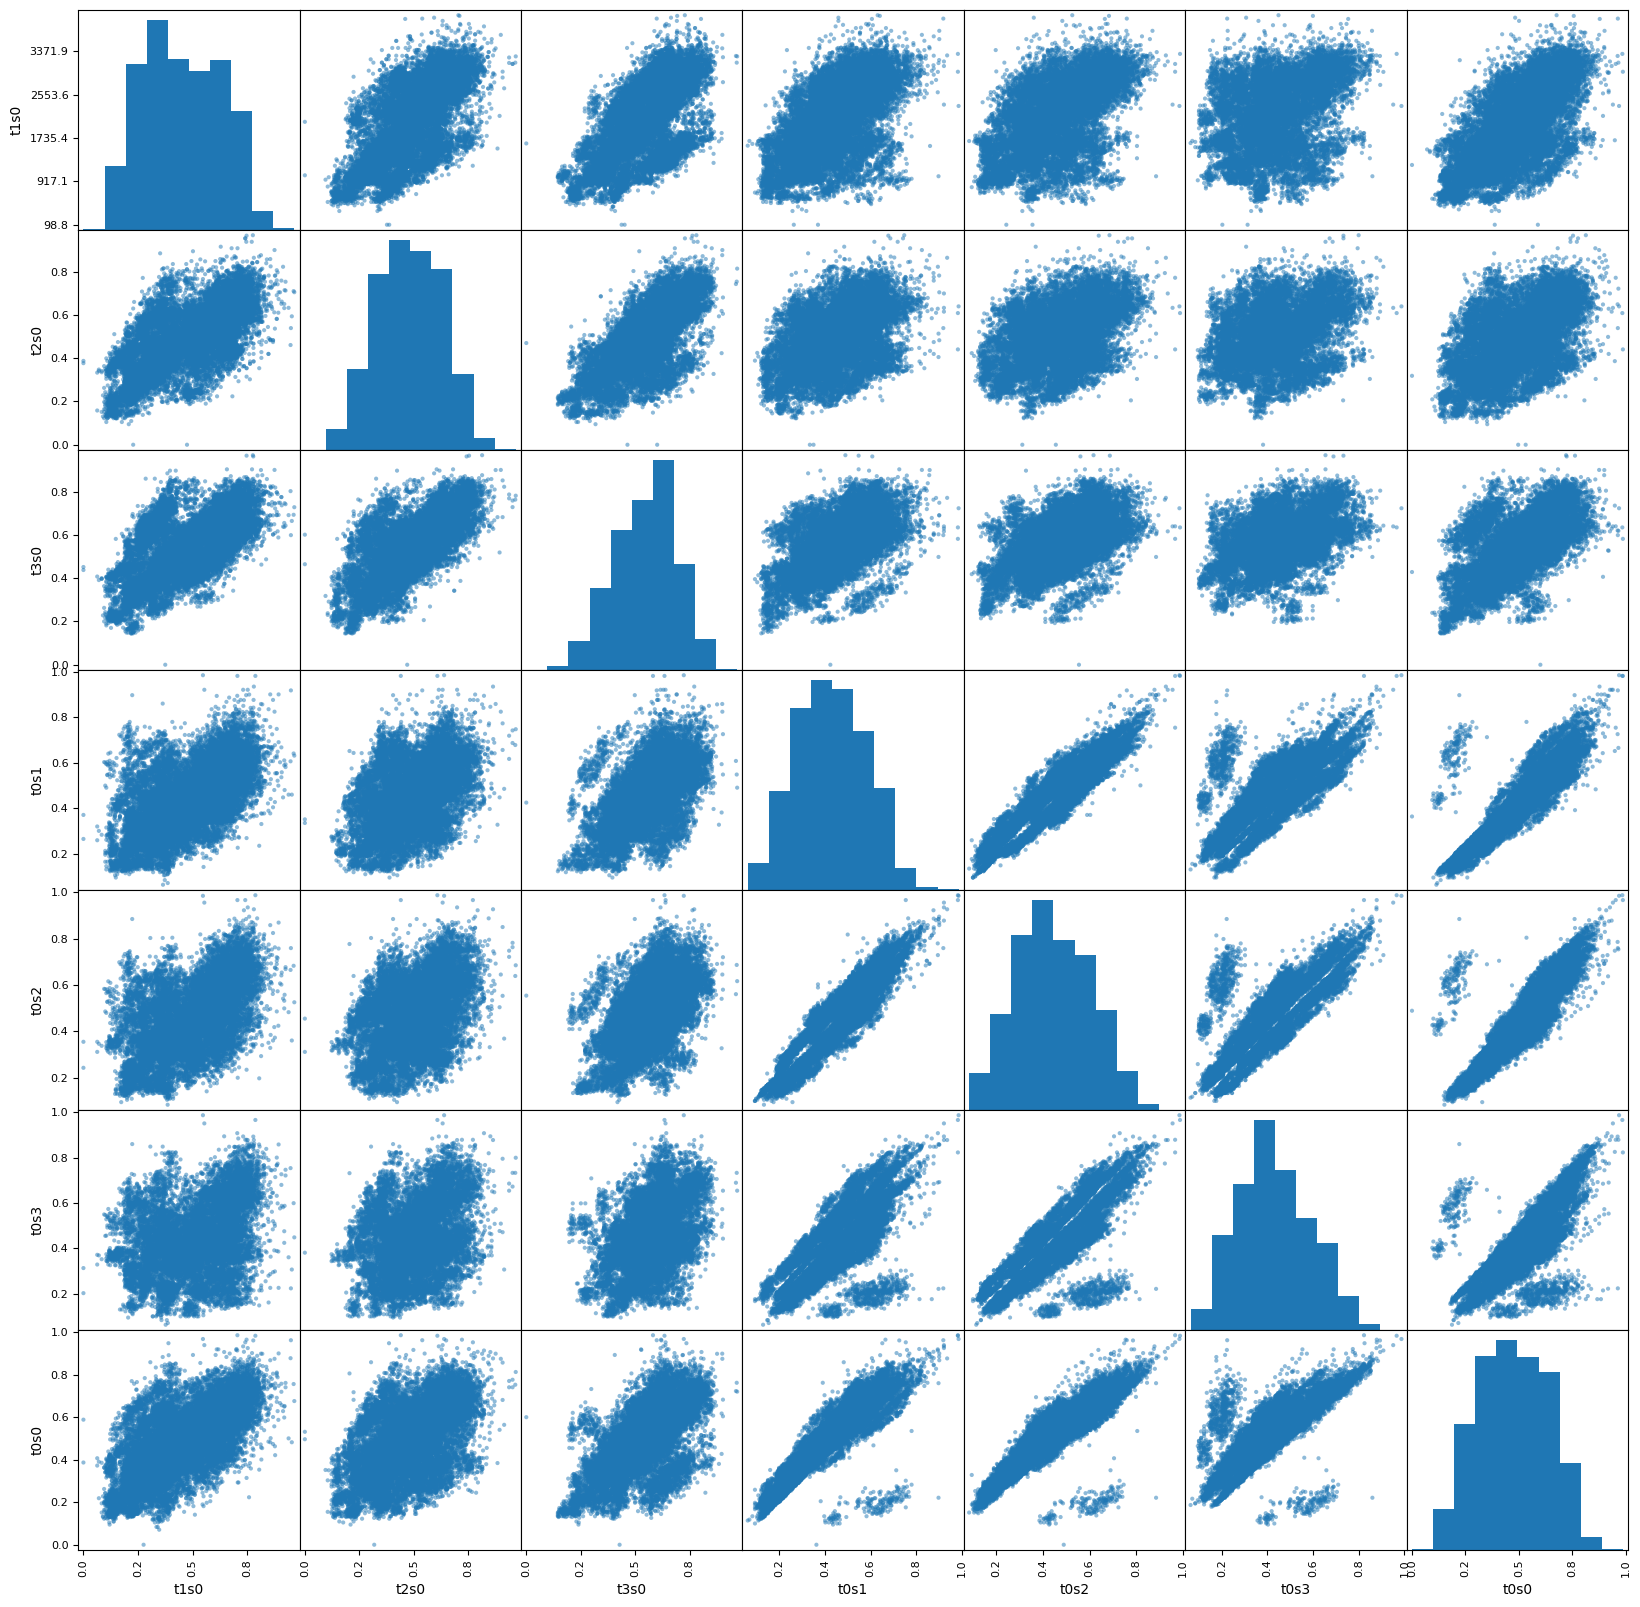

In [27]:
#apply sqrt transformation to lag features
df_train_sqrt = df_train.copy()

for feature in lag_features:
    df_train_sqrt[feature] = np.sqrt(df_train_sqrt[feature])

# Create the scatter matrix plot
plt.figure(figsize=(20, 20))
sm = scatter_matrix(df_train_sqrt[lag_features], figsize=(20, 20))

# Fix the axis labels to one decimal place
for ax in sm.ravel():
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1f}'))

plt.show()

<Figure size 2000x2000 with 0 Axes>

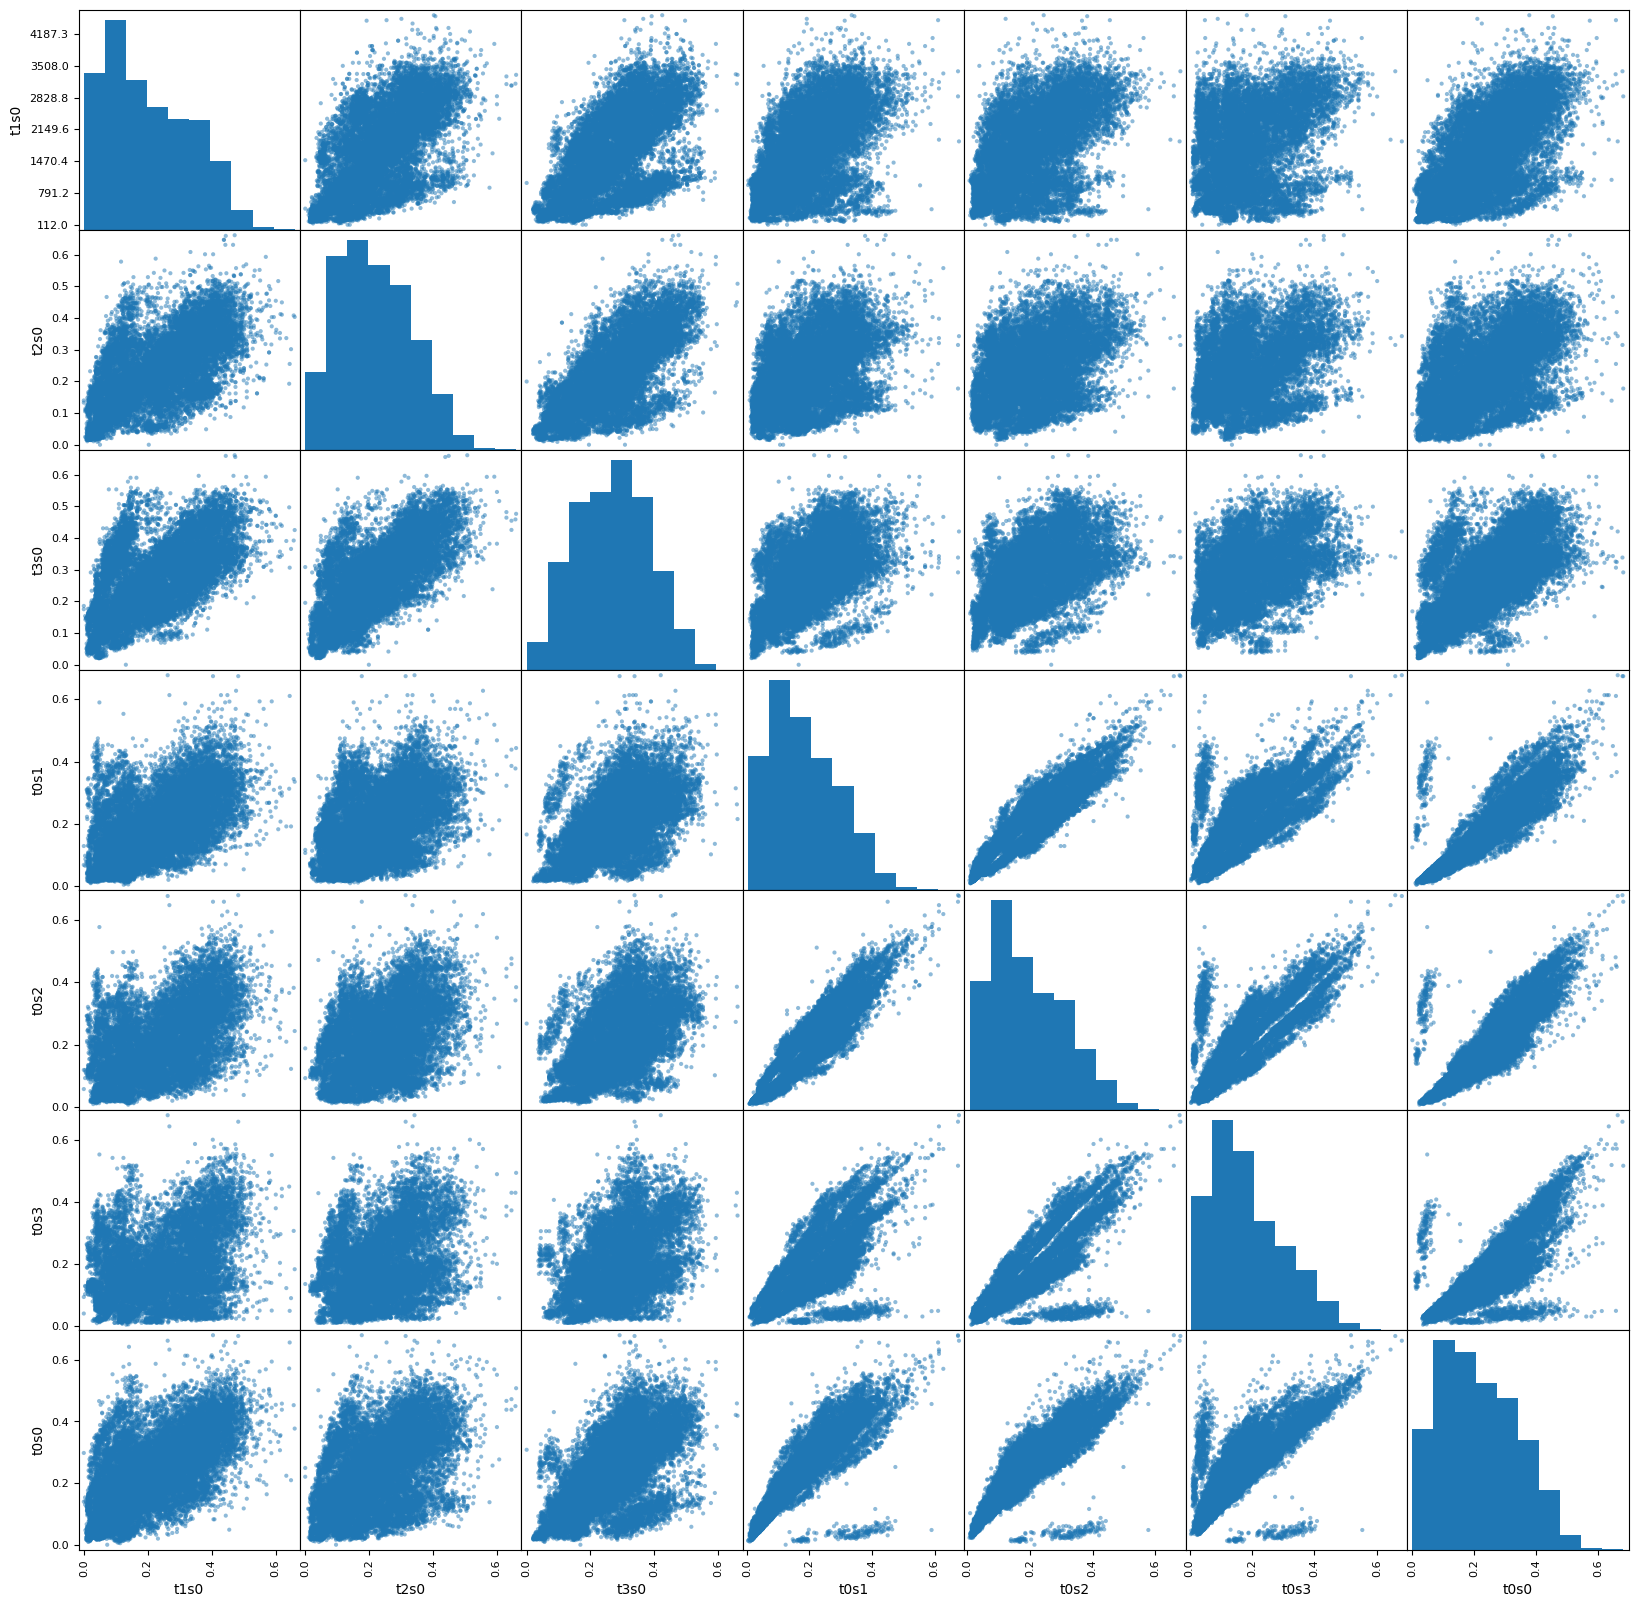

In [28]:
# apply log transformation to lag features
df_train_log = df_train.copy()

for feature in lag_features:
    df_train_log[feature] = np.log1p(df_train_log[feature])

# Create the scatter matrix plot
plt.figure(figsize=(20, 20))
sm = scatter_matrix(df_train_log[lag_features], figsize=(20, 20))

# Fix the axis labels to one decimal place
for ax in sm.ravel():
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1f}'))

plt.show()

In [29]:
import feature_engineering

corr = feature_engineering.get_features_correlated_to_target(df_train[lag_features], 't0s0')
corr_sqrt = feature_engineering.get_features_correlated_to_target(df_train_sqrt[lag_features], 't0s0')
corr_log = feature_engineering.get_features_correlated_to_target(df_train_log[lag_features], 't0s0')

# print avg
print('Average correlation:', np.mean(corr))
print('Average correlation (sqrt):', np.mean(corr_sqrt))
print('Average correlation (log):', np.mean(corr_log))

Average correlation: 0.76
Average correlation (sqrt): 0.762857142857143
Average correlation (log): 0.7628571428571428


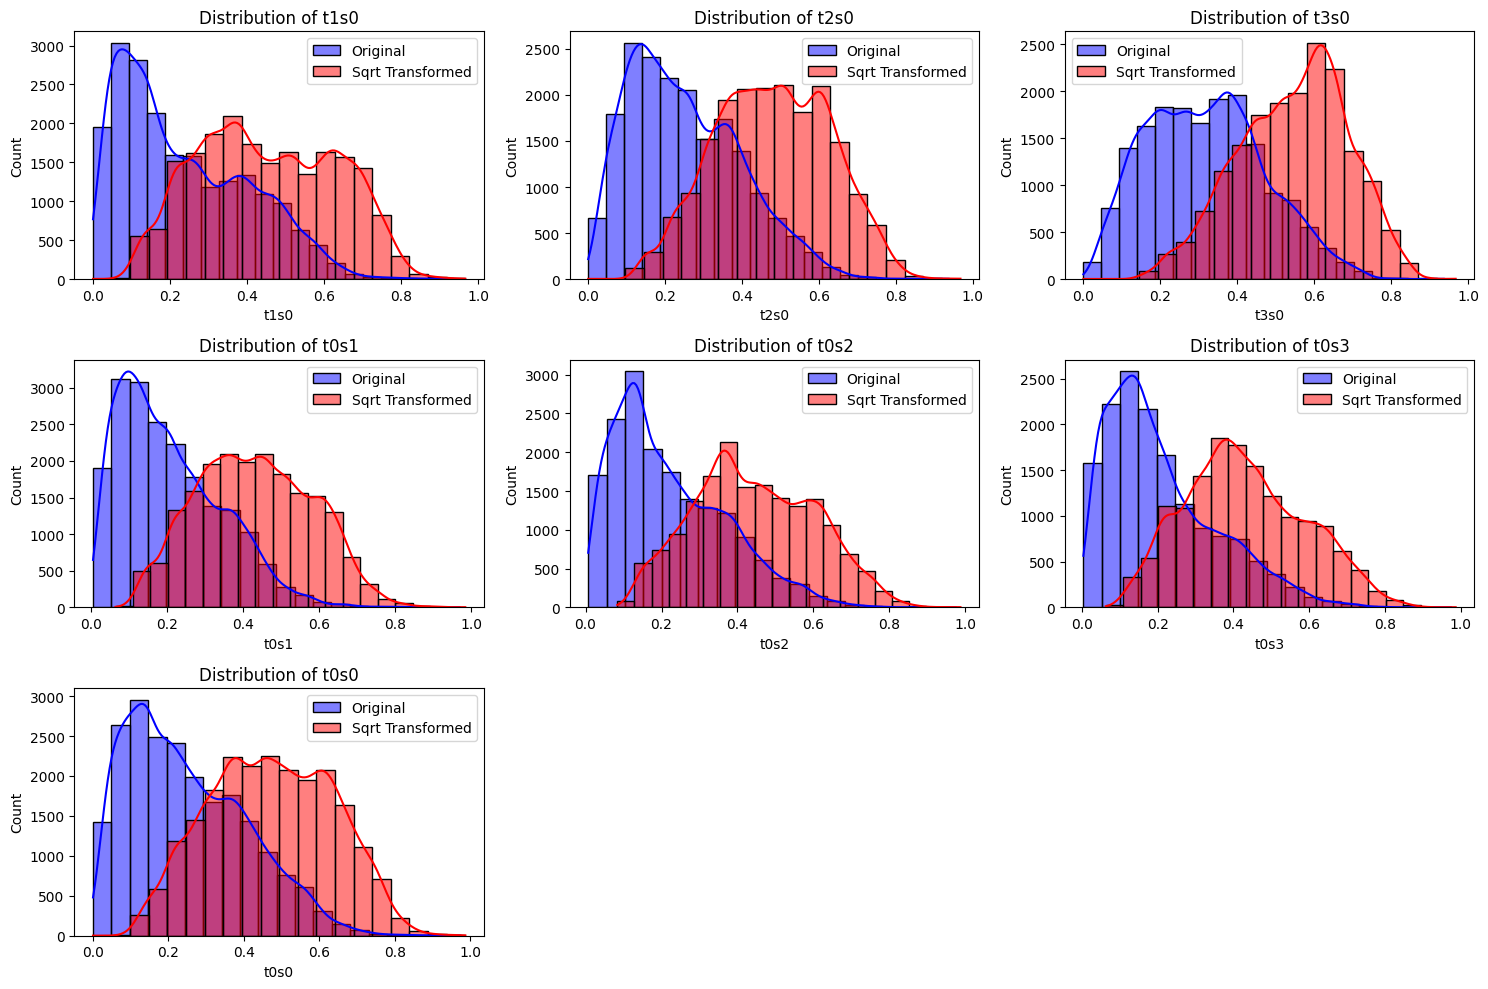

In [30]:
# Explore distribution of lag variables
plt.figure(figsize=(15, 10))
for i, col in enumerate(lag_features):
    plt.subplot(3, 3, i+1)
    sns.histplot(df_train[col].dropna(), bins=20, kde=True, color='blue', label='Original')
    sns.histplot(df_train_sqrt[col].dropna(), bins=20, kde=True, color='red', label='Sqrt Transformed')
    plt.title(f'Distribution of {col}')
    plt.legend()
plt.tight_layout()
plt.show()


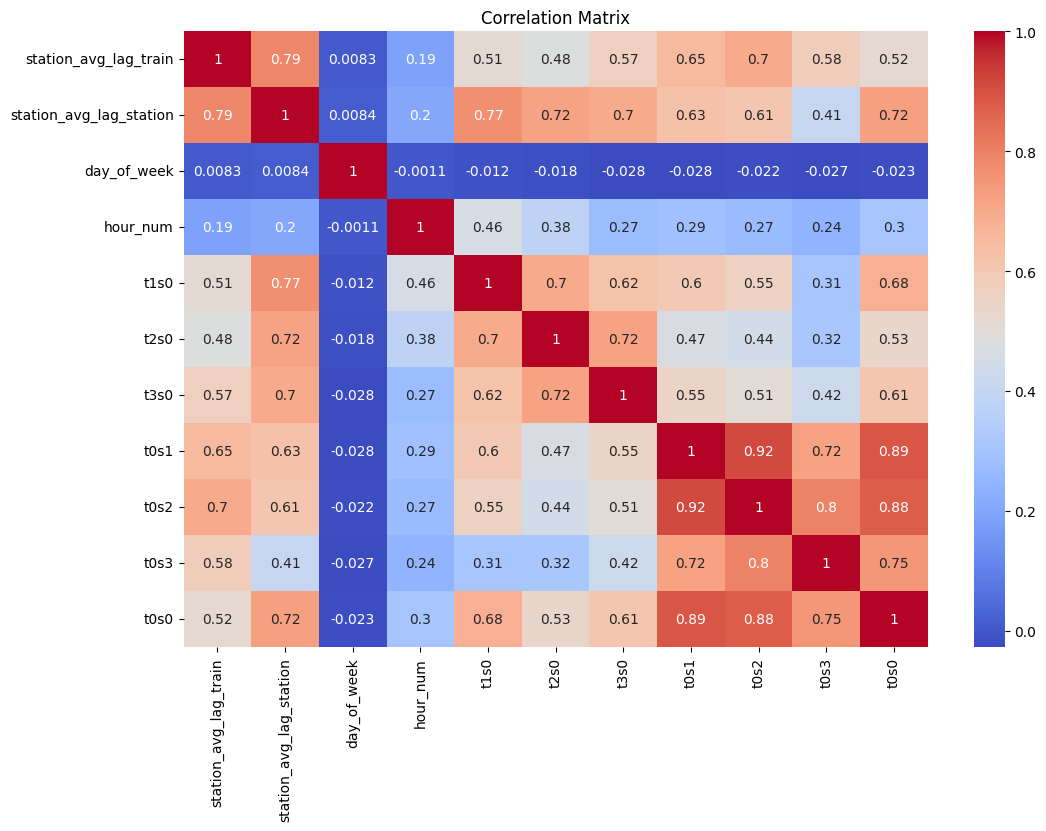

In [40]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_train_sqrt[all_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Testing Preprocessing

In [31]:
df_pre_test, df_pre_train = preprocessData(*get_dataset())

df_pre_test

hour      t1s0      t2s0      t3s0      t0s1      t0s2      t0s3  \
0       0.4  0.511859  0.369053  0.746324  0.508920  0.598331  0.665582   
1       0.4  0.664831  0.634035  0.630555  0.700714  0.608276  0.544977   
2       0.4  0.279285  0.254951  0.663144  0.370135  0.433590  0.463681   
3       0.4  0.503984  0.516527  0.532565  0.490918  0.428952  0.380789   
4       0.4  0.614817  0.631664  0.581378  0.469042  0.394968  0.357771   
...     ...       ...       ...       ...       ...       ...       ...   
21778   0.2  0.322490  0.379695  0.375227  0.308221  0.443825  0.431145   
21779   0.4  0.418330  0.637966  0.752330  0.301662  0.248998  0.431145   
21780   0.6  0.611555  0.396232  0.567309  0.576194  0.554977  0.450555   
21781   0.4  0.363318  0.388587  0.668581  0.730068  0.691375  0.661060   
21782   0.4  0.340588  0.477493  0.798947  0.542218  0.582237  0.689202   

       station_avg_lag_train  station_avg_lag_station      t0s0  
0                   0.311418                 0.314791  0.707107  
1                   0.375376                 0.240365  0.723187  
2                   0.178852                 0.195931  0.523450  
3                   0.192798                 0.108314  0.562139  
4                   0.339551                 0.179304  0.559464  
...                      ...                      ...       ...  
21778               0.119048                 0.081410  0.371484  
21779               0.238922                 0.187362  0.337639  
21780               0.268423                 0.209076  0.578792  
21781               0.238922                 0.187362  0.756968  
21782               0.311418                 0.314791  0.738918  

[21783 rows x 10 columns]

<Figure size 2000x2000 with 0 Axes>

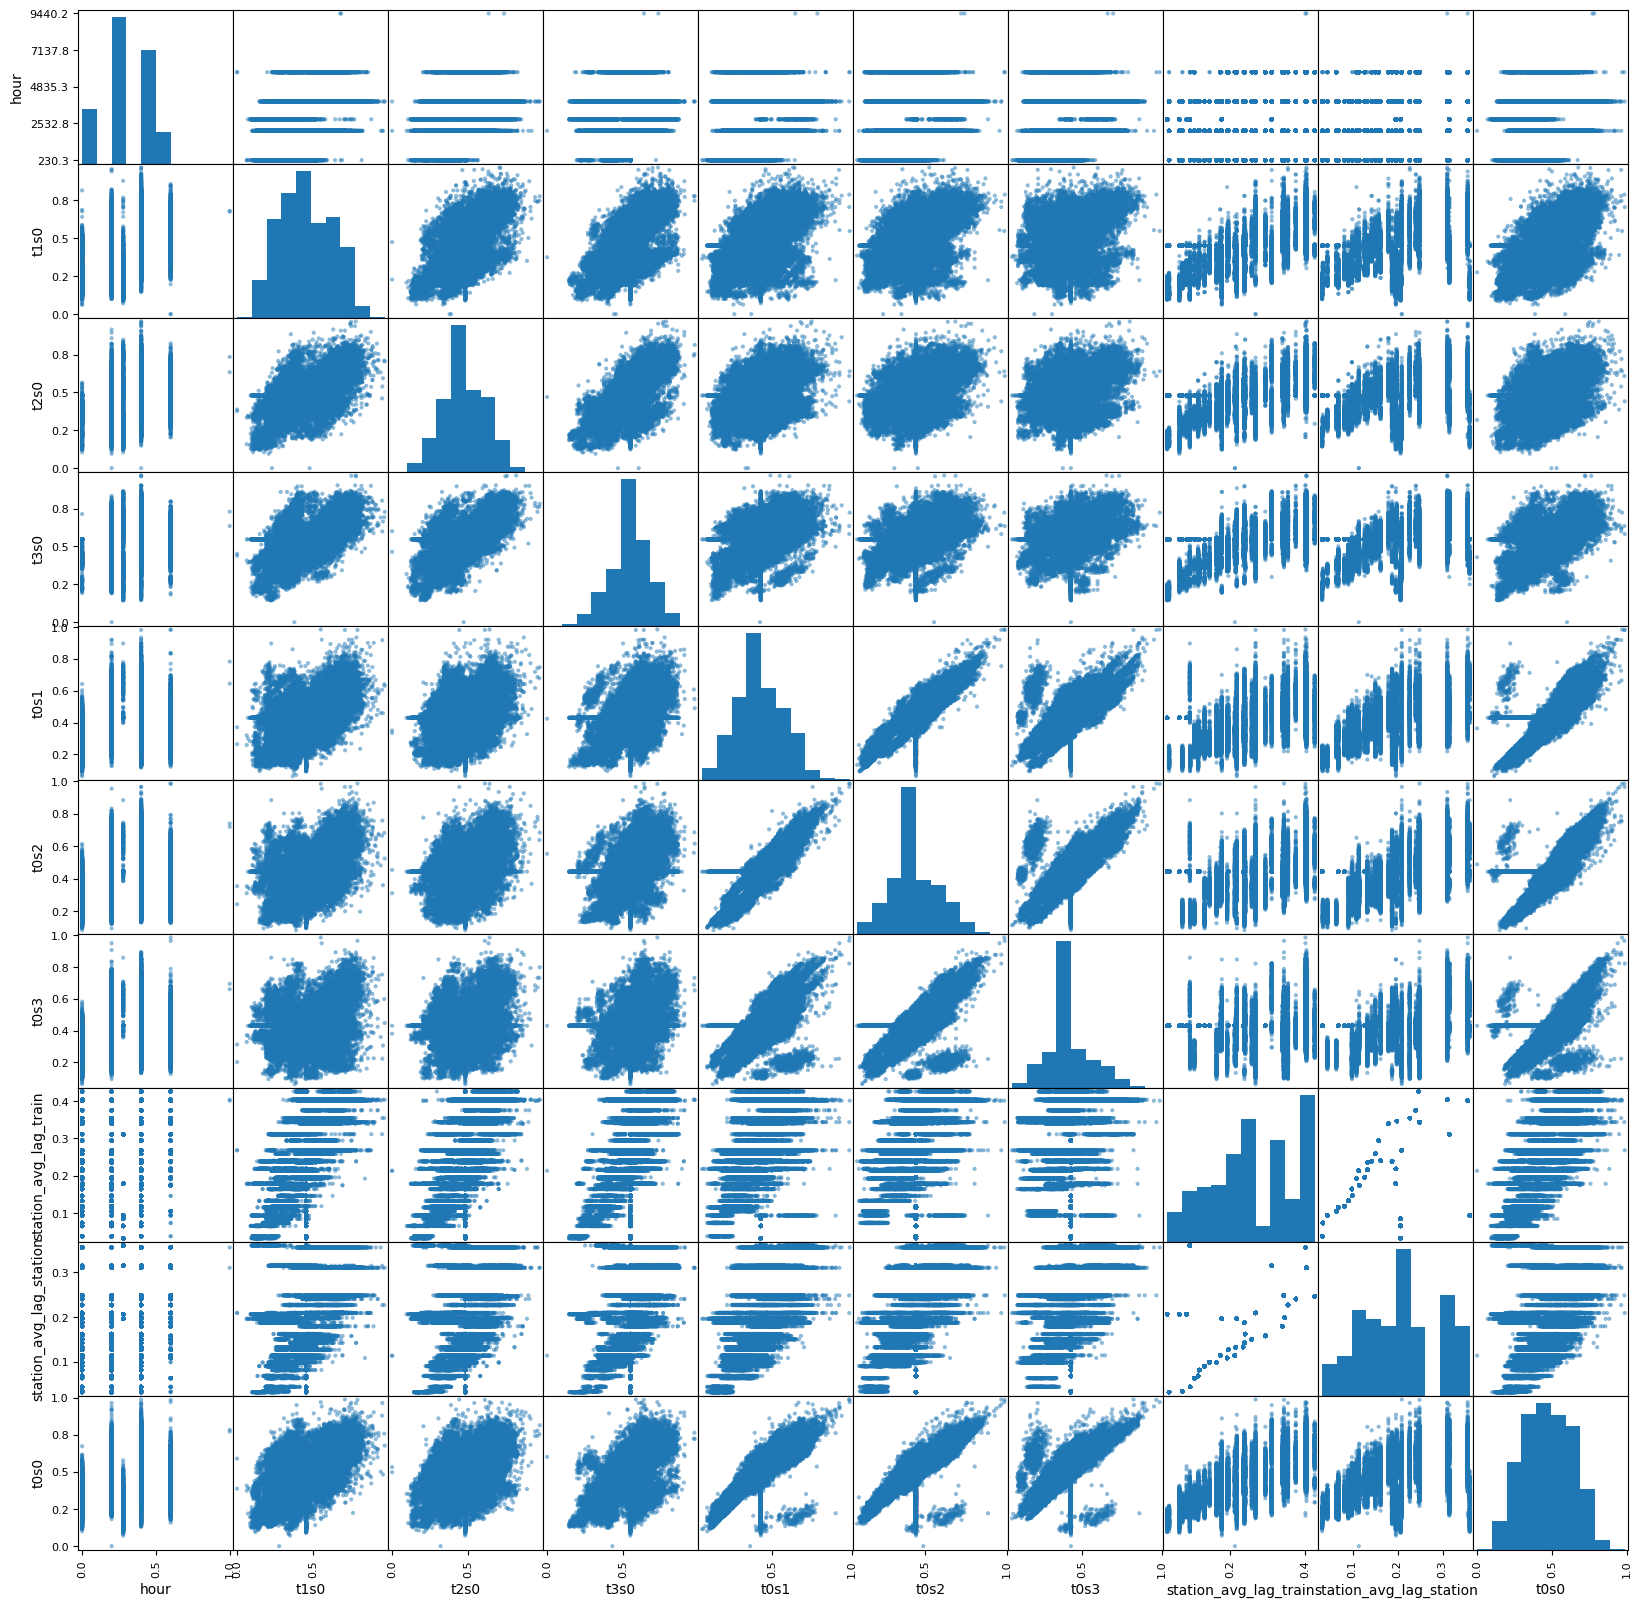

In [32]:
# Create the scatter matrix plot
plt.figure(figsize=(20, 20))
sm = scatter_matrix(df_pre_test, figsize=(20, 20))

# Fix the axis labels to one decimal place
for ax in sm.ravel():
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1f}'))

plt.show()

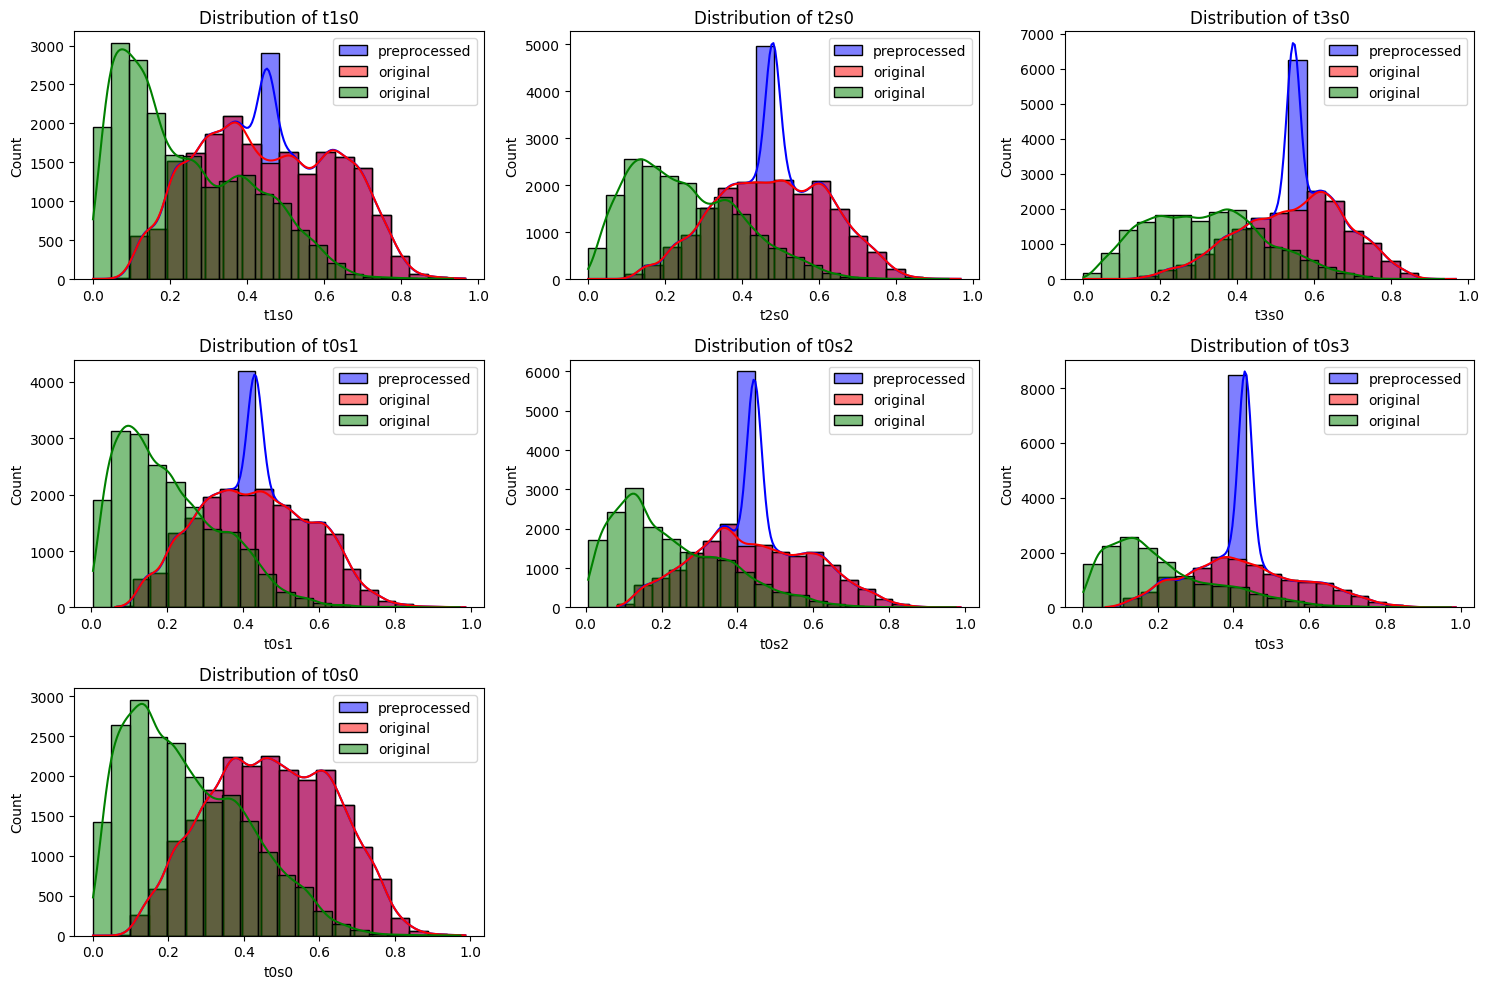

In [33]:
df_pre_test, df_pre_train = preprocessData(*get_dataset())

# Explore distribution of lag variables
plt.figure(figsize=(15, 10))
for i, col in enumerate(lag_features):
    plt.subplot(3, 3, i+1)
    sns.histplot(df_pre_test[col].dropna(), bins=20, kde=True, color='blue', label='preprocessed')
    sns.histplot(df_train_sqrt[col].dropna(), bins=20, kde=True, color='red', label='original') 
    sns.histplot(df_train[col].dropna(), bins=20, kde=True, color='green', label='original') 
    plt.title(f'Distribution of {col}')
    plt.legend()
plt.tight_layout()
plt.show()